# LIBRARIES

In [1]:
!pip install -r requirements.txt
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO

mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists


In [2]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

tf.compat.v1.set_random_seed(2019)
init_notebook_mode(connected=True)
RANDOM_SEED = 123

2024-12-10 17:58:22.645845: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 17:58:22.658372: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 17:58:22.769481: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 17:58:22.894039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 17:58:23.013508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
def load_data(dir_path):
    """
        Load images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


In [4]:
IMG_DIR = 'project_images/'
# split the data by train/val/test
for class_name in os.listdir(IMG_DIR):
    if not class_name.startswith('.'):
        num_images = len(os.listdir(IMG_DIR + class_name))
        for (n, file_name) in enumerate(os.listdir(IMG_DIR + class_name)):
            img_path = IMG_DIR + class_name + '/' + file_name
                        
            if n < 5:
                shutil.copy(img_path, 'TEST/' + class_name.upper() + '/' + file_name)
            elif n < 0.8*num_images:
                shutil.copy(img_path, 'TRAIN/'+ class_name.upper() + '/' + file_name)
            else:
                shutil.copy(img_path, 'VAL/'+ class_name.upper() + '/' + file_name)

        print("IMG_DIR: ", IMG_DIR)
        print("class_name: ", class_name)
        print("num_images: ", num_images)
        print("file_name: ", file_name)
        print("img_path: ", img_path)

IMG_DIR:  project_images/
class_name:  NO
num_images:  20
file_name:  nomotif9.png
img_path:  project_images/NO/nomotif9.png
IMG_DIR:  project_images/
class_name:  YES
num_images:  35
file_name:  motif30.png
img_path:  project_images/YES/motif30.png


In [5]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR)
X_test, y_test, _ = load_data(TEST_DIR)
X_val, y_val, _ = load_data(VAL_DIR)

100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


34 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 57.94it/s]


9 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 35.58it/s]

11 images loaded from VAL/ directory.


In [6]:
def plot_samples(x, y, labels_dict, n=50):
    """
        Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = x[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Motif: {}'.format(labels_dict[index]))
        plt.show()

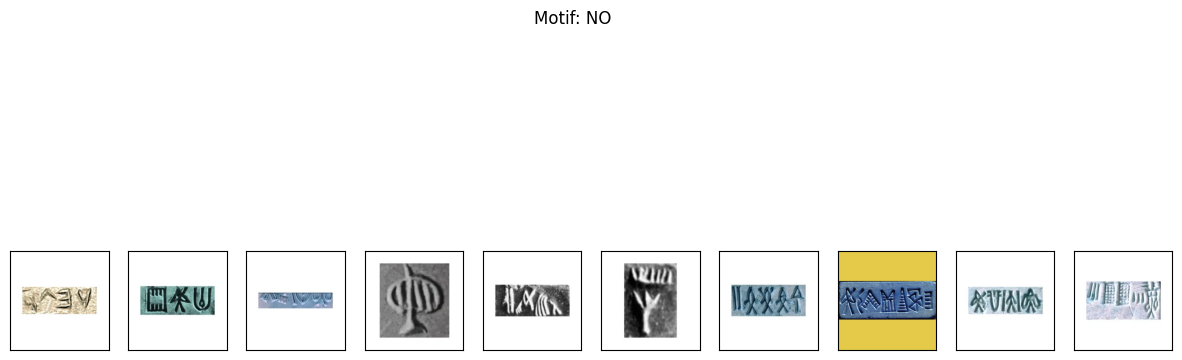

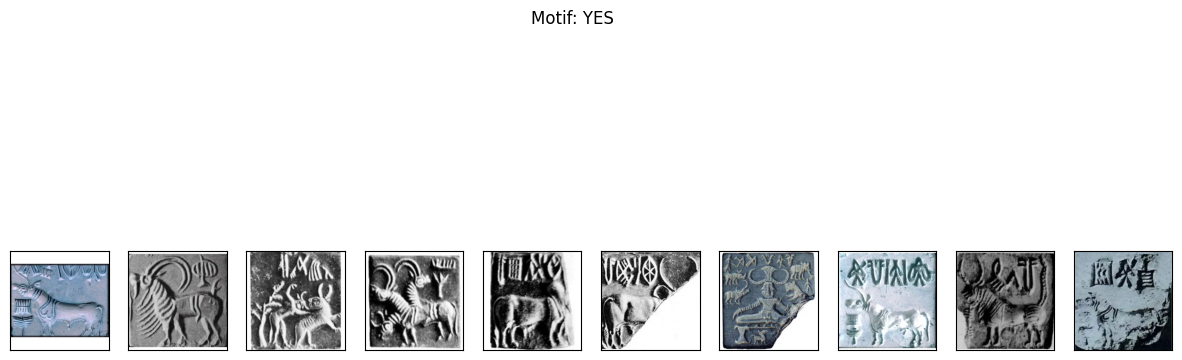

In [7]:
plot_samples(X_train, y_train, labels, 10)

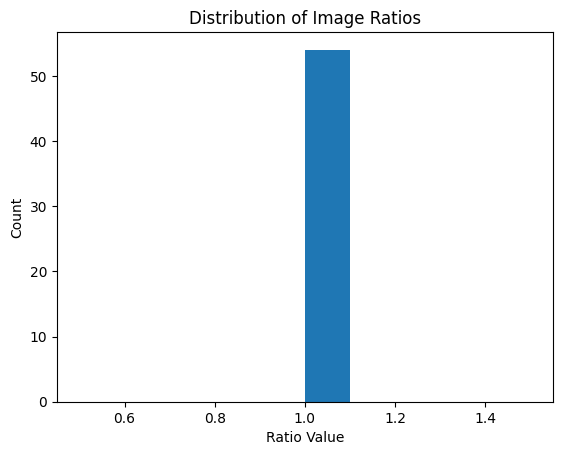

In [8]:

# Distribution of Image Ratio
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [9]:
def preprocess_imgs(set_name, img_size):
    """
        Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [10]:
IMG_SIZE = (224,224)
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-106.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-111.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

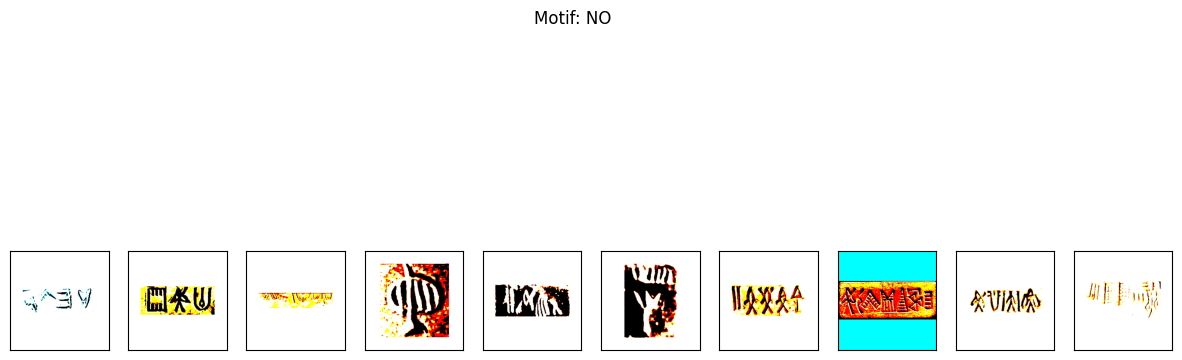

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-117.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

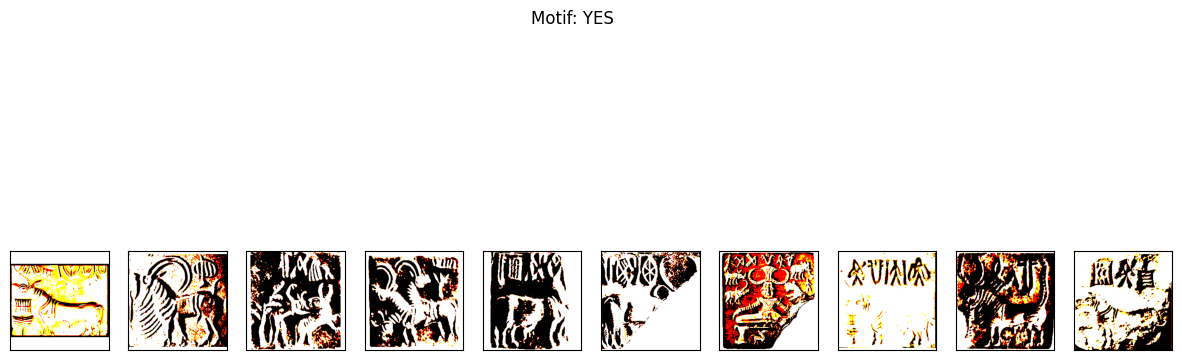

In [11]:
plot_samples(X_train_prep, y_train, labels, 10)

In [12]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [13]:
os.mkdir('preview')
x = X_train[19]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

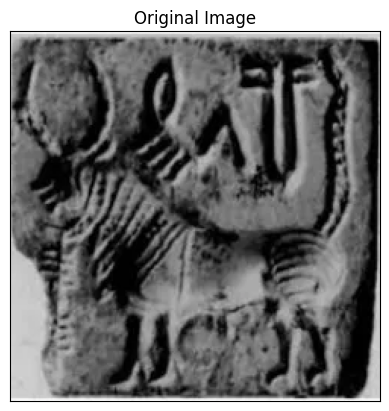

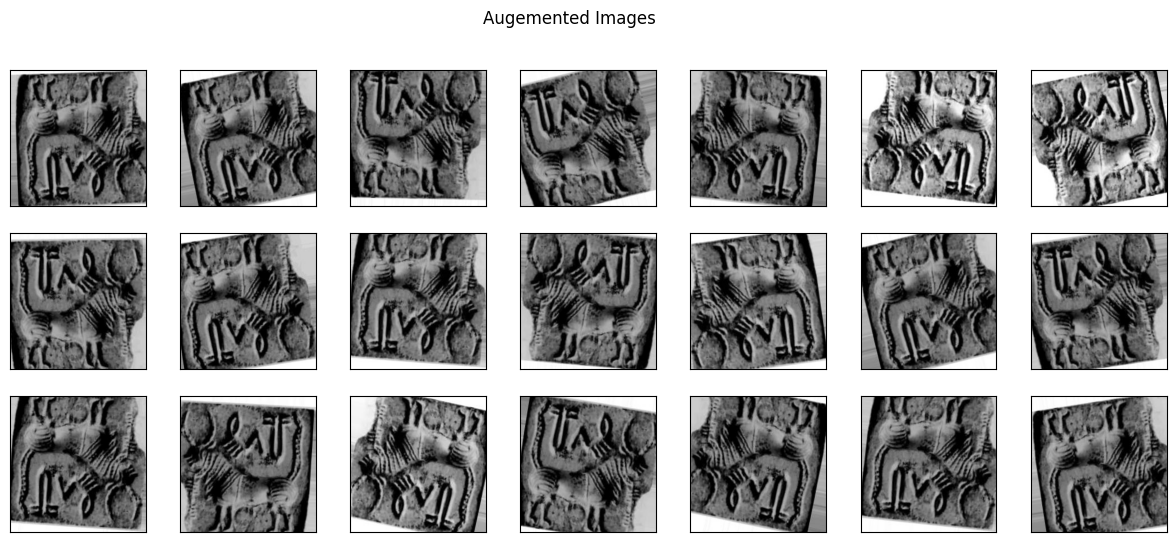

In [14]:
plt.imshow(X_train[19])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [15]:
!rm -rf preview/

In [27]:
# Define the model architecture
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2,'softmax')
])

/home/darshan/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [17]:
from tensorflow.keras.optimizers import Adam
adam=Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',

    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 34 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [19]:
train_generator

In [20]:
# Define the model architecture
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2,'softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 10
)


/home/darshan/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10


/home/darshan/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.6176 - loss: 1.0289 - val_accuracy: 0.3636 - val_loss: 1.3926
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - accuracy: 0.6097 - loss: 1.5364 - val_accuracy: 0.6364 - val_loss: 1.5834
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6176 - loss: 1.2365 - val_accuracy: 0.8182 - val_loss: 0.5582
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.7898 - loss: 0.5873 - val_accuracy: 0.9091 - val_loss: 0.2291
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1392 - val_accuracy: 0.9091 - val_loss: 0.1853
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 587ms/step - accuracy: 0.9400 - loss: 0.2295 - val_accuracy: 0.9091 - val_loss: 0.1760
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9412 - loss: 0.1326 - val_accuracy: 0.9091 - val_loss: 0.2340
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.9700 - loss: 0.1149 - val_accuracy: 0.9091 - val_loss: 0.0879
Epoch 9/10
2/2 

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,507,656 (127.82 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,438 (85.21 MB)

In [22]:
# Evaluate the model on a test dataset

predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions[:,1]]

_, train_acc = model.evaluate(X_val_prep, y_val, verbose=0)
_, test_acc = model.evaluate(X_test_prep, y_test, verbose=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


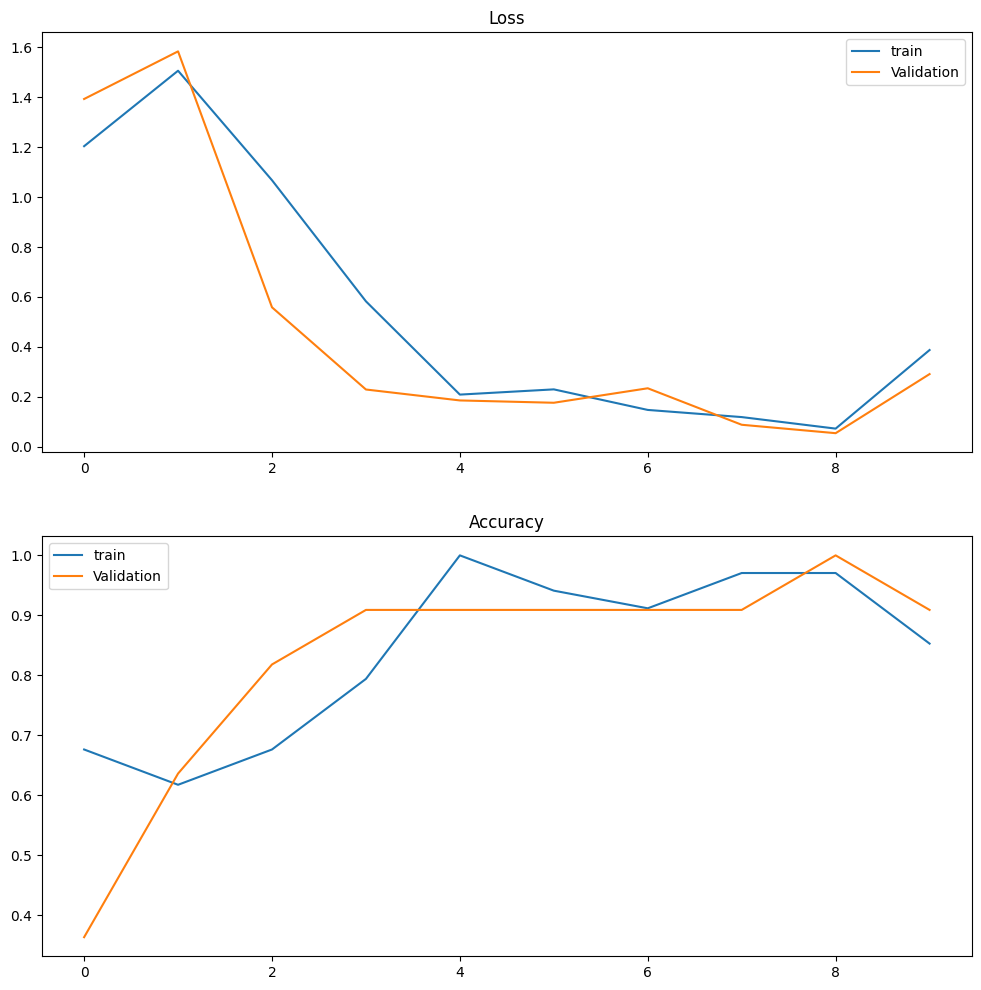

In [23]:
plt.figure(figsize=(12,12))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [24]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.909, Test: 0.889


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.888889
Precision: 0.800000
Recall: 1.000000
F1 score: 0.888889
